- **Input Embeddings**: Token + Positional embeddings for each token
- **Contextual Embeddings**: Embedding after each layer

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from transformers import BertTokenizer, BertModel
from datasets import load_dataset

### Mean polling doesn't work sentences

In [9]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_sentence_embedding(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    attention_mask = encoded_input['attention_mask'] # to indicate which tokens should be attended to, and which should not

    # Get the model output (without the specific classification  head)
    with torch.no_grad():
        output = model(**encoded_input)

    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())

    # mean pooling operation, considering the BERT input_mask and padding
    sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sentence_embedding.flatten().tolist()

In [5]:
def cosine_similarity_matrix(features):
    # Calculate the cosine similarity
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

In [6]:
# Helper function to plot similarity matrix
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1.2)
    g = sns.heatmap(
        sim,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0.0,
        vmax=1.0,
        cmap="YlGnBu")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

In [16]:
messsages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US.",
    "Global warming is real.",

    # Food and health
    "An apple a day, keeps the doctors away.",
    "Eating strawberries is healthy.",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "What is your age?"
]

<Axes: title={'center': 'Semantic Textual Similarity'}>

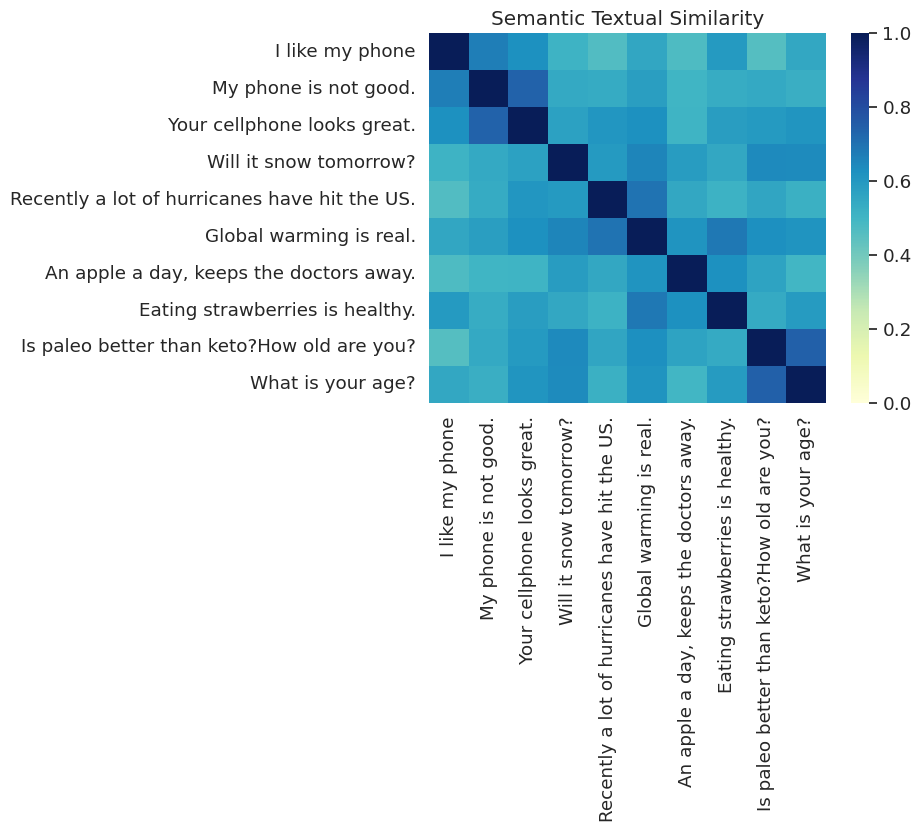

In [10]:
embeddings = []
for t in messsages:
    embeddings.append(get_sentence_embedding(t))

plot_similarity(messsages, embeddings, 90)

In [11]:
sts_dataset = load_dataset("mteb/stsbenchmark-sts")
sts = pd.DataFrame({'sent1': sts_dataset['test']['sentence1'], 
                   'sent2': sts_dataset['test']['sentence2'], 
                   'score': [x/5 for x in sts_dataset['test']['score']]})
sts.head(10)

Generating test split: 100%|██████████| 1379/1379 [00:00<00:00, 52774.19 examples/s]


,sent1,sent2,score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400
4,A man is playing a harp.,A man is playing a keyboard.,0.3000
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000
7,A man is playing the drums.,A man is playing the guitar.,0.4400
8,A man is playing guitar.,A lady is playing the guitar.,0.4400
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428


In [12]:
def sim_two_sentences(s1, s2):
    emb1 = get_sentence_embedding(s1)
    emb2 = get_sentence_embedding(s2)
    sim = cosine_similarity_matrix([emb1, emb2])
    return sim[0][1]

n_examples = 50

sts = sts.head(n_examples)
sts['avg_bert_score'] = np.vectorize(sim_two_sentences)(sts['sent1'], sts['sent2'])

In [13]:
sts.head(10)

,sent1,sent2,score,avg_bert_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588


The **Pearson correlation coefficient** (often denoted as \( r \)) is a statistical measure that quantifies the linear relationship between two variables. Here are the key points:

### Definition
- **Formula**: It is calculated as the covariance of the two variables divided by the product of their standard deviations.
$$ r = \frac{\text{cov}(X, Y)}{\sigma_X \sigma_Y} $$
where \( \text{cov}(X, Y) \) is the covariance of variables \( X \) and \( Y \), and \( \sigma_X \) and \( \sigma_Y \) are the standard deviations of \( X \) and \( Y \), respectively¹(https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)²(https://www.scribbr.com/statistics/pearson-correlation-coefficient/).

### Interpretation
- **Range**: The value of \( r \) ranges from -1 to 1.
  - **1**: Perfect positive linear correlation.
  - **0**: No linear correlation.
  - **-1**: Perfect negative linear correlation.
- **Strength and Direction**: The closer the value is to 1 or -1, the stronger the linear relationship. Positive values indicate that as one variable increases, the other also increases. Negative values indicate that as one variable increases, the other decreases²(https://www.scribbr.com/statistics/pearson-correlation-coefficient/)³(https://link.springer.com/referenceworkentry/10.1007/978-1-4020-5614-7_2569).

### Applications
- **Data Analysis**: Used to determine the strength and direction of the linear relationship between two variables.
- **Predictive Modeling**: Helps in identifying variables that have a significant linear relationship, which can be useful in regression analysis and other predictive models¹(https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)²(https://www.scribbr.com/statistics/pearson-correlation-coefficient/).

Would you like to see an example of how to calculate the Pearson correlation coefficient, or do you have a specific dataset in mind?

Source: Conversation with Copilot, 2024/9/2
(1) Pearson correlation coefficient - Wikipedia. https://en.wikipedia.org/wiki/Pearson_correlation_coefficient.
(2) Pearson Correlation Coefficient (r) | Guide & Examples - Scribbr. https://www.scribbr.com/statistics/pearson-correlation-coefficient/.
(3) Pearson’s Correlation Coefficient | SpringerLink. https://link.springer.com/referenceworkentry/10.1007/978-1-4020-5614-7_2569.

In [14]:
pc = scipy.stats.pearsonr(sts['score'], sts['avg_bert_score'])
print(f"Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}")

Pearson correlation coefficient = 0.32100172202695454
p-value = 0.02303013509739929


### Sentences embeddings

<Axes: title={'center': 'Semantic Textual Similarity'}>

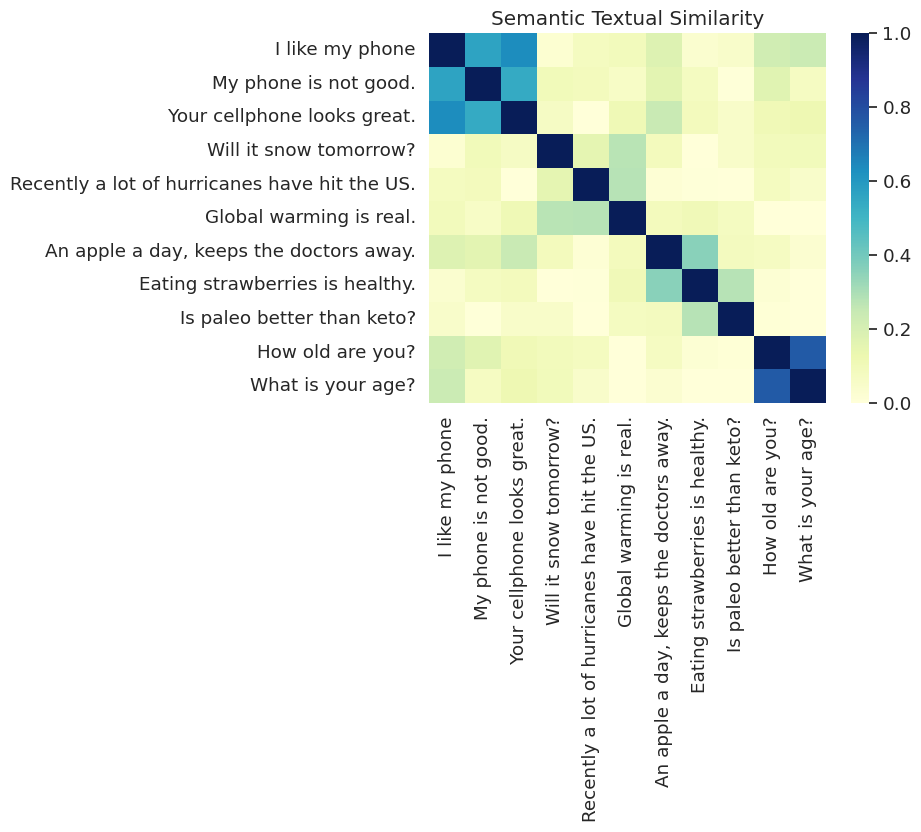

In [17]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = []
for t in messsages:
    embeddings.append(list(model.encode(t)))

plot_similarity(messsages, embeddings, 90)

In [18]:
def sim_two_sentences(s1, s2):
    emb1 = list(model.encode(s1))
    emb2 = list(model.encode(s2))
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0][1]

sts['mini_LM_score'] = np.vectorize(sim_two_sentences)(sts['sent1'], sts['sent2'])
sts.head(10)

,sent1,sent2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588,0.5096


In [19]:
pc = scipy.stats.pearsonr(sts['score'], sts['mini_LM_score'])
print(f"Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}")

Pearson correlation coefficient = 0.9303740673726044
p-value = 1.4823857251915091e-22


Contrastive loss is a type of loss function used in machine learning, particularly in tasks involving similarity learning, such as in Siamese networks. It works by comparing pairs of samples and adjusting their representations based on their similarity:

- **For similar pairs**: The loss function minimizes the distance between their embeddings.
- **For dissimilar pairs**: The loss function maximizes the distance between their embeddings, often with a margin to prevent overlap¹(https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/)²(https://arxiv.org/abs/2012.09740).

This approach helps the model learn to distinguish between similar and dissimilar samples effectively³(https://codelabsacademy.com/blog/understanding-contrastive-loss-and-reconstruction-loss-in-machine-learning)⁴(https://www.baeldung.com/cs/contrastive-learning).

Is there a specific application or example of contrastive loss you're curious about?

Source: Conversation with Copilot, 2024/9/2
(1) Contrastive Loss for Siamese Networks with Keras and TensorFlow. https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/.
(2) [2012.09740] Understanding the Behaviour of Contrastive Loss - arXiv.org. https://arxiv.org/abs/2012.09740.
(3) Understanding Contrastive Loss and Reconstruction Loss in Machine .... https://codelabsacademy.com/blog/understanding-contrastive-loss-and-reconstruction-loss-in-machine-learning.
(4) An Introduction to Contrastive Learning | Baeldung on Computer Science. https://www.baeldung.com/cs/contrastive-learning.

Contrastive loss is a type of loss function used in machine learning, particularly in tasks involving similarity learning, such as in Siamese networks. It works by comparing pairs of samples and adjusting their representations based on their similarity:

- **For similar pairs**: The loss function minimizes the distance between their embeddings.
- **For dissimilar pairs**: The loss function maximizes the distance between their embeddings, often with a margin to prevent overlap¹(https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/)²(https://arxiv.org/abs/2012.09740).

This approach helps the model learn to distinguish between similar and dissimilar samples effectively³(https://codelabsacademy.com/blog/understanding-contrastive-loss-and-reconstruction-loss-in-machine-learning)⁴(https://www.baeldung.com/cs/contrastive-learning).

Is there a specific application or example of contrastive loss you're curious about?

Source: Conversation with Copilot, 2024/9/2
(1) Contrastive Loss for Siamese Networks with Keras and TensorFlow. https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/.
(2) [2012.09740] Understanding the Behaviour of Contrastive Loss - arXiv.org. https://arxiv.org/abs/2012.09740.
(3) Understanding Contrastive Loss and Reconstruction Loss in Machine .... https://codelabsacademy.com/blog/understanding-contrastive-loss-and-reconstruction-loss-in-machine-learning.
(4) An Introduction to Contrastive Learning | Baeldung on Computer Science. https://www.baeldung.com/cs/contrastive-learning.